# Graph Machine Learning



In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

In [2]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.6/886.6 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
from torch_geometric.utils import to_dense_adj
from torch_geometric.datasets import FacebookPagePage
from torch.utils.data import random_split, DataLoader

## Facebook Page-Page dataset

This dataset was introduced by [Rozemberczki et al. in 2019](https://arxiv.org/abs/1909.13021). It was created using the Facebook Graph API in November 2017. In this dataset, each of the 22,470 nodes represents an official Facebook page. Pages are connected when there are mutual likes between them. Node features (128-dim vectors) are created from textual descriptions written by the owners of these pages. Our goal is to classify each node into one of four categories:

- politicians
- companies
- television shows
- governmental organizations.

The Facebook Page-Page dataset is similar to the previous one: it’s a social network with a node classification task. However, there are three major differences with Cora:

The number of nodes is much higher (2,708 versus 22,470)
The dimensionality of the node features decreased dramatically (from 1,433 to 128)
The goal is to classify each node into four categories instead of seven (which is easier since there are fewer options)
The following figure is a visualization of the dataset using Gephi. First, nodes with few connections have been filtered out to improve performance. The size of the remaining nodes depends on their number of connections, and their color indicates the category they belong to. Finally, two layouts have been applied: Fruchterman-Reingold and ForceAtlas2.

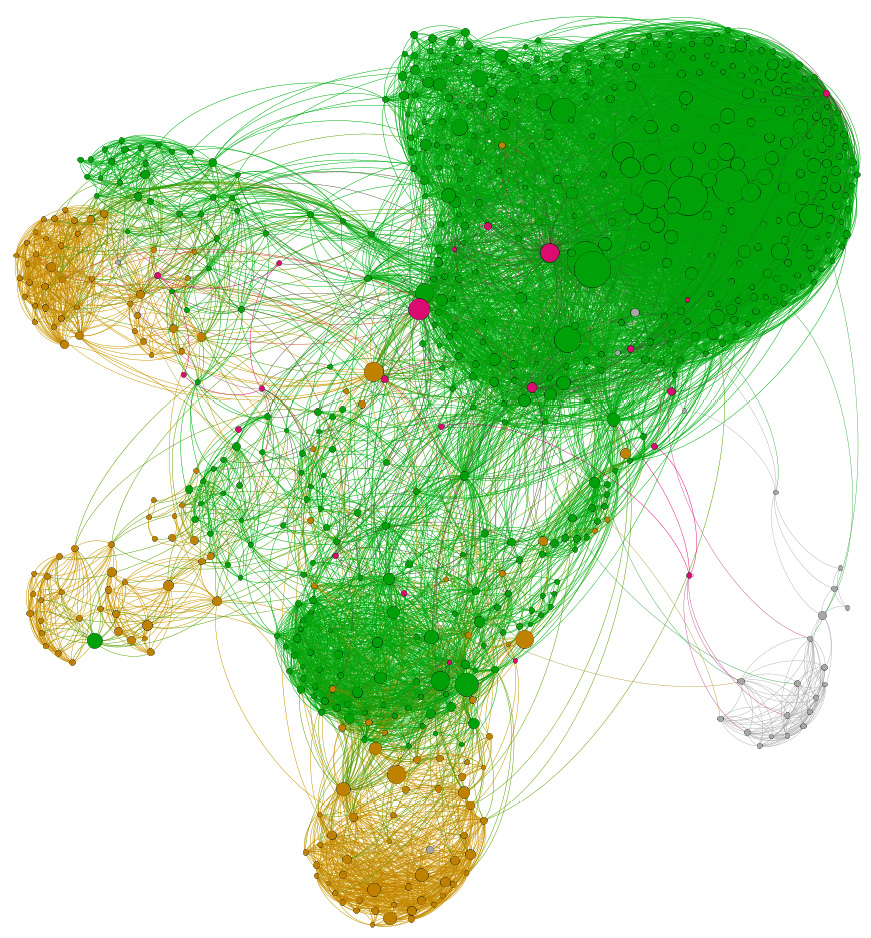

### Load dataset

In [4]:
from torch_geometric.datasets import FacebookPagePage

# Import dataset from PyTorch Geometric
dataset = FacebookPagePage(root=".")

data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

# Create masks
data.train_mask = range(18000)
data.val_mask   = range(18001, 20000)
data.test_mask  = range(20001, 22470)

Processing...
Done!


Dataset: FacebookPagePage()
-----------------------
Number of graphs: 1
Number of nodes: 22470
Number of features: 128
Number of classes: 4

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: True


## Visualizing the graph

In [5]:
# Tensor with edge index
data.edge_index

tensor([[    0, 18427,     1,  ...,  5563, 22425, 22425],
        [18427,     0, 21708,  ...,  5563, 22425, 22425]])

In [6]:
# From Tensor to Numpy array
data.edge_index.numpy()

array([[    0, 18427,     1, ...,  5563, 22425, 22425],
       [18427,     0, 21708, ...,  5563, 22425, 22425]])

In [7]:
# From Tensor to DataFrame
pd.DataFrame(data.edge_index.numpy())

,0,1,2,3,4,5,6,7,8,9,...,341994,341995,341996,341997,341998,341999,342000,342001,342002,342003
0,0,18427,1,21708,1,22208,1,22171,1,6829,...,20188,20188,22340,22383,22348,22348,5563,5563,22425,22425
1,18427,0,21708,1,22208,1,22171,1,6829,1,...,20188,20188,22383,22340,22348,22348,5563,5563,22425,22425


In [8]:
# Final transformation
pd.DataFrame(data.edge_index.numpy().T, columns=['start_node','end_node'])

,start_node,end_node
0,0,18427
1,18427,0
2,1,21708
3,21708,1
4,1,22208
...,...,...
341999,22348,22348
342000,5563,5563
342001,5563,5563
342002,22425,22425


In [9]:
edge_index_list = pd.DataFrame(data.edge_index.numpy().T, columns=['start_node','end_node'])

In [10]:
G = nx.from_pandas_edgelist(edge_index_list, "start_node", "end_node")# Metodo en network ex para grenerar grafo

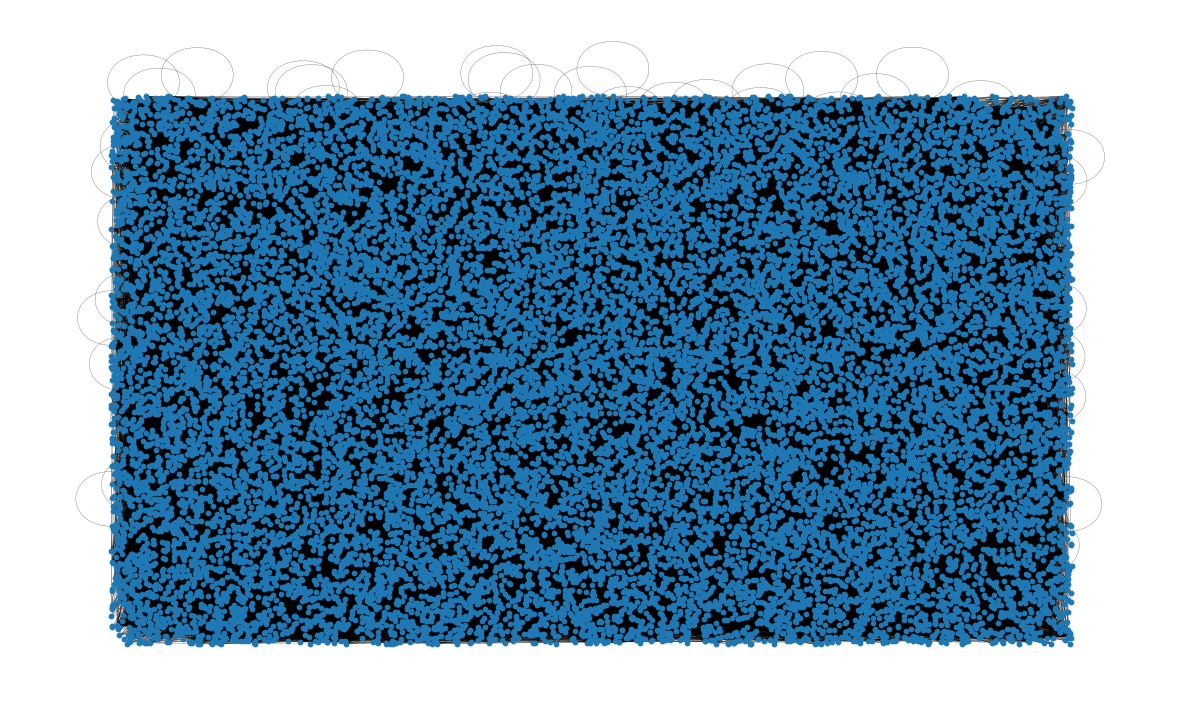

In [15]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)#Bola de pelos, no permite identificar facilmente los nodos centrales

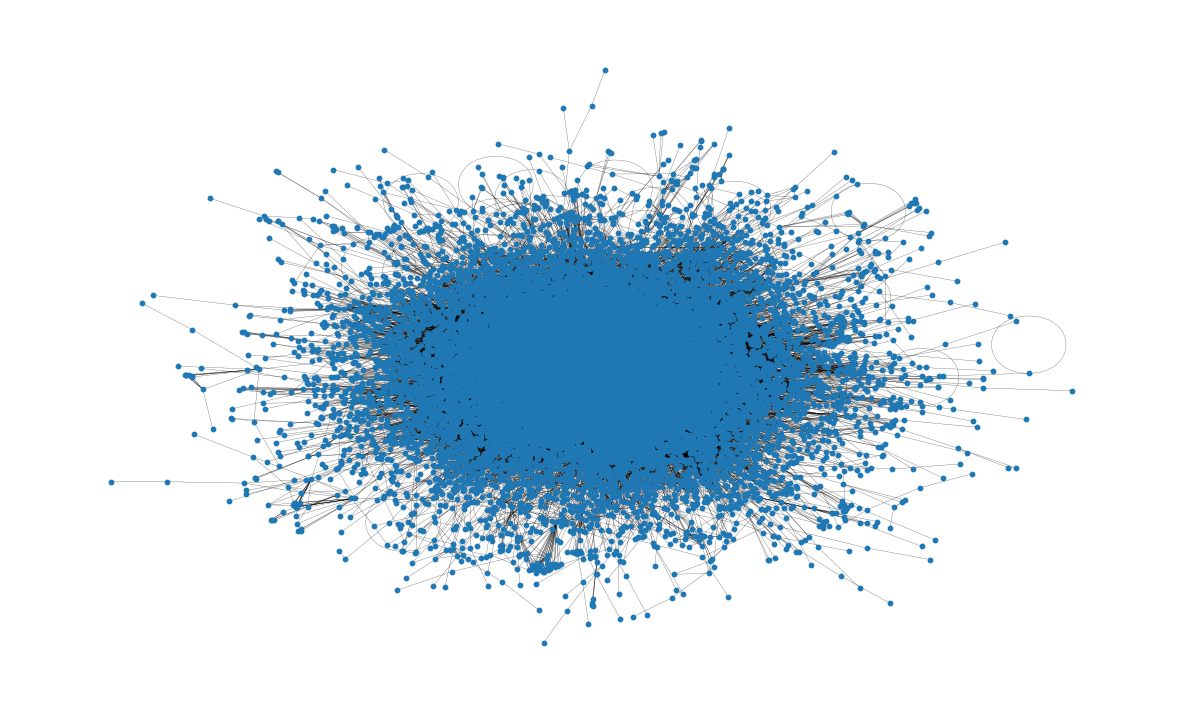

In [16]:
pos = nx.spring_layout(G, iterations=15, seed=1721)#Spring layaout va agragando nodos e iteraciones
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

### Split dataset

In [11]:
# Dataset
dataset = FacebookPagePage(root=".")
data = dataset[0]
data.train_mask = range(18000)
data.val_mask   = range(18001, 20000)
data.test_mask  = range(20001, 22470)

### Build Adjacency Matrix

In [12]:
# Adjacency matrix
# Crea matriz de adyacencia
adjacency = to_dense_adj(data.edge_index)[0]
adjacency += torch.eye(len(adjacency))
adjacency

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

### Build MLP class

In [13]:
df_x = pd.DataFrame(data.x.numpy())#Extrae 178 features de los 22470 nodos
df_x['label'] = pd.DataFrame(data.y)
df_x.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.223700,-0.284379,-0.224216,-0.209509,-0.255755,-0.21514,-0.375903,-0.223836,0
1,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.234818,-0.223700,-0.284379,-0.197935,-0.147256,-0.255755,-0.21514,-0.364134,-0.128634,2
2,-0.262576,-0.265053,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.210461,-0.25101,3.222161,...,-0.273229,-0.223700,-0.284379,-0.224216,-0.209509,-0.255755,-0.21514,-0.375903,-0.223836,1
3,-0.246378,-0.276483,-0.241991,-0.299327,-0.299159,-0.270681,-0.307051,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.223700,-0.265534,-0.080353,-0.209509,-0.250560,-0.18026,-0.375903,-0.223836,2
4,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.175312,-0.272613,-0.224216,-0.181153,-0.255755,-0.21514,-0.370639,-0.223836,3


In [15]:
print(pd.DataFrame(data))#Extrae 178 features de los 22470 nodos
#df_x['label'] = pd.DataFrame(data.y)
#df_x.head()

            0                                                  1
0           x  [[tensor(-0.2626), tensor(-0.2765), tensor(-0....
1  edge_index  [[tensor(0), tensor(18427), tensor(1), tensor(...
2           y  [tensor(0), tensor(2), tensor(1), tensor(2), t...
3  train_mask  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
4    val_mask  (18001, 18002, 18003, 18004, 18005, 18006, 180...
5   test_mask  (20001, 20002, 20003, 20004, 20005, 20006, 200...


In [16]:
import torch
torch.manual_seed(0)
from torch.nn import Linear#Función linear basica
import torch.nn.functional as F #Varias funciones


def accuracy(y_pred, y_true):
    """Calculate accuracy.""" #Metrica accuracy
    return torch.sum(y_pred == y_true) / len(y_true)

In [17]:
# MLP
class MLP(torch.nn.Module):
    """Multilayer Perceptron"""
    def __init__(self, dim_in, dim_h, dim_out):#Metodo init dim de entrada, dim capas ocultas, dim salida
        super().__init__()#Trae todos los atributos de inicialización de la clase padre Torch.Module
        self.linear1 = Linear(dim_in, dim_h)#Objeto 1 dim entrada y transforma a capa oculta
        self.linear2 = Linear(dim_h, dim_out)#Toma capa oculta y capa de salida

    def forward(self, x):#Metodo camina adelante fordward
        x = self.linear1(x)#De linear 1 toma x
        x = torch.relu(x)#Relu --> Reduce reprocidad de errores entre cientificos
        x = self.linear2(x)#Linear2
        return F.log_softmax(x, dim=1)#Log de softmax donde le pasamos x y se indica la cantidad de neuronas

    def fit(self, data, epochs):# Se define dentro de torch
        criterion = torch.nn.CrossEntropyLoss()#Como categorical cross entropy
        optimizer = torch.optim.Adam(self.parameters(),#toma parametros ya declarados para implementarlos
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()#Inicia optimizadores en 0
            out = self(data.x)#Determina salida basado en la categoria seleccionada
            loss = criterion(out[data.train_mask], data.y[data.train_mask])#Validacion
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])# Calculo accuracy
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):#Cada 20 epocas imprime lo siguiente
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()#Decorador de eficiencia computacional
    def test(self, data):
        self.eval()
        out = self(data.x)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

### Build GNN class

In [18]:
class SparseLayer(torch.nn.Module):#Es una capa densa
    def __init__(self, dim_in, dim_out): #Metodo init dim de entrada, dim salida
        super().__init__()
        self.linear = Linear(dim_in, dim_out, bias=False)

    def forward(self, x, adjacency):    #Metodo camina adelante fordward
        x = self.linear(x)
        x = torch.sparse.mm(adjacency, x)#Multiplica la matriz de adyacencia por x
        return x

In [19]:
# GNN
class GNN(torch.nn.Module):
    """Vanilla Graph Neural Network"""
    def __init__(self, dim_in, dim_h, dim_out): #Metodo init dim de entrada, dim capas ocultas, dim salida
        super().__init__()                      #Trae todos los atributos de inicialización de la clase padre Torch.Module
        self.gnn1 = SparseLayer(dim_in, dim_h)  #Objeto 1 dim entrada y transforma a capa oculta
        self.gnn2 = SparseLayer(dim_h, dim_out) #Toma capa oculta y capa de salida

    def forward(self, x, adjacency):      #Metodo camina adelante fordward
        h = self.gnn1(x, adjacency)       #De gnn1 toma x y sus adjacentes
        h = torch.relu(h)                 #Relu
        h = self.gnn2(h, adjacency)       #De gnn2 toma h y sus adjacentes
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, adjacency)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, adjacency)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

### Run models and compare

In [20]:
# MLP
mlp = MLP(dataset.num_features, 16, dataset.num_classes)
print(mlp)
mlp.fit(data, epochs=100)
acc = mlp.test(data)
print(f'\nMLP test accuracy: {acc*100:.2f}%\n')

# GCN
gnn = GNN(dataset.num_features, 16, dataset.num_classes)
print(gnn)
gnn.fit(data, epochs=100)
acc = gnn.test(data)
print(f'\nGNN test accuracy: {acc*100:.2f}%')

MLP(
  (linear1): Linear(in_features=128, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=4, bias=True)
)
Epoch   0 | Train Loss: 1.466 | Train Acc: 17.61% | Val Loss: 1.47 | Val Acc: 16.61%
Epoch  20 | Train Loss: 0.677 | Train Acc: 73.16% | Val Loss: 0.69 | Val Acc: 71.74%
Epoch  40 | Train Loss: 0.584 | Train Acc: 76.83% | Val Loss: 0.62 | Val Acc: 75.04%
Epoch  60 | Train Loss: 0.556 | Train Acc: 77.97% | Val Loss: 0.61 | Val Acc: 75.39%
Epoch  80 | Train Loss: 0.539 | Train Acc: 78.79% | Val Loss: 0.61 | Val Acc: 75.24%
Epoch 100 | Train Loss: 0.525 | Train Acc: 79.33% | Val Loss: 0.61 | Val Acc: 75.69%

MLP test accuracy: 75.21%

GNN(
  (gnn1): SparseLayer(
    (linear): Linear(in_features=128, out_features=16, bias=False)
  )
  (gnn2): SparseLayer(
    (linear): Linear(in_features=16, out_features=4, bias=False)
  )
)
Epoch   0 | Train Loss: 52.936 | Train Acc: 27.18% | Val Loss: 44.15 | Val Acc: 26.11%
Epoch  20 | Train Loss: 4.316 | Train Acc: 80.3

### Split dataset
User a pytorch random split and debug model classes...

In [21]:
# Verificar los índices del df
print('DataFrame Indices:')
print(df_x.index)

DataFrame Indices:
RangeIndex(start=0, stop=22470, step=1)


In [22]:
df_x = df_x.reset_index(drop=True)
print('DataFrame Indices (después de reset_index):')
print(df_x.index)

DataFrame Indices (después de reset_index):
RangeIndex(start=0, stop=22470, step=1)


In [32]:
# Proporciones (70% entrenamiento, 15% validación, 15% prueba)
# Calcula el tamaño de cada conjunto
total_df = len(df_x)
train_size = int(0.7 * total_df)
val_size = int(0.15 * total_df)
test_size = total_df - train_size - val_size

# Divide el conjunto de datos en entrenamiento, validación y prueba
train_data, val_data, test_data = random_split(df_x, [train_size, val_size, test_size])


In [33]:
print(f'Number of training examples:   {len(train_data)}')
print(f'Number of validation examples: {len(val_data)}')
print(f'Number of testing examples:    {len(test_data)}')

Number of training examples:   15728
Number of validation examples: 3370
Number of testing examples:    3372


In [39]:
# Verificar índices de las divisiones
print('Train Data Indices:')
print(train_data.dataset.index)
print('Validation Data Indices:')
print(val_data.dataset.index)
print('Test Data Indices:')
print(test_data.dataset.index)

Train Data Indices:
RangeIndex(start=0, stop=22470, step=1)
Validation Data Indices:
RangeIndex(start=0, stop=22470, step=1)
Test Data Indices:
RangeIndex(start=0, stop=22470, step=1)


In [27]:
df_x.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.223700,-0.284379,-0.224216,-0.209509,-0.255755,-0.21514,-0.375903,-0.223836,0
1,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.234818,-0.223700,-0.284379,-0.197935,-0.147256,-0.255755,-0.21514,-0.364134,-0.128634,2
2,-0.262576,-0.265053,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.210461,-0.25101,3.222161,...,-0.273229,-0.223700,-0.284379,-0.224216,-0.209509,-0.255755,-0.21514,-0.375903,-0.223836,1
3,-0.246378,-0.276483,-0.241991,-0.299327,-0.299159,-0.270681,-0.307051,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.223700,-0.265534,-0.080353,-0.209509,-0.250560,-0.18026,-0.375903,-0.223836,2
4,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.175312,-0.272613,-0.224216,-0.181153,-0.255755,-0.21514,-0.370639,-0.223836,3


In [36]:
print(f'Train size:      {int(0.7 * len(df_x))}')
print(f'Validation size: {int(0.15 * len(df_x))}')
print(f'Test size:       {int(0.15 * len(df_x))}')

Train size: 15728
Validation size: 3370
Test size: 3370


In [37]:
# Imprime la longitud de los conjuntos
print(f'Número de muestras en entrenamiento: {len(train_data)}')
print(f'Número de muestras en validación:    {len(val_data)}')
print(f'Número de muestras en prueba:        {len(test_data)}')

Número de muestras en entrenamiento: 15728
Número de muestras en validación:    3370
Número de muestras en prueba:        3372


In [38]:
# Verificar si hay filas duplicadas en df_x
duplicates_x = df_x[df_x.duplicated()]
print(f'Filas duplicadas en df_x: {len(duplicates_x)}')

Filas duplicadas en df_x: 13


In [42]:
# Create mini-batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=64, shuffle=True)

In [43]:
# Let's check it!
print('\nTrain loader:')
for i, batch in enumerate(train_loader):
    print(f' - Batch {i}: {batch}')

print('\nValidation loader:')
for i, batch in enumerate(val_loader):
    print(f' - Batch {i}: {batch}')

print('\nTest loader:')
for i, batch in enumerate(test_loader):
    print(f' - Batch {i}: {batch}')


Train loader:


KeyError: ignored

In [44]:
# Verificar si el índice 11873 existe en el conjunto de entrenamiento
index_to_check = 11873
if index_to_check < len(train_loader):
    print(f'El índice {index_to_check} existe en el conjunto de validación.')
else:
    print(f'El índice {index_to_check} no existe en el conjunto de validación.')

El índice 11873 no existe en el conjunto de validación.


In [45]:
print(f'Tamaño de df_x: {len(df_x)}')
print(f'Tamaño del conjunto de entrenamiento: {len(train_loader.dataset)}')
print(f'Tamaño del conjunto de entrenamiento: {len(val_loader.dataset)}')
print(f'Tamaño del conjunto de entrenamiento: {len(test_loader.dataset)}')


Tamaño de df_x: 22470
Tamaño del conjunto de entrenamiento: 15728
Tamaño del conjunto de entrenamiento: 3370
Tamaño del conjunto de entrenamiento: 3372


In [47]:
print('Train Loader Data:')
for i, batch in enumerate(train_loader):
    print(1)
    #print(f' - Batch {i}: Data {batch}')


Train Loader Data:


KeyError: ignored

In [46]:
# Itera a través de train_loader para ver el contenido
for i, data in enumerate(train_loader):
    batch_indices = data.batch
    print(f'Batch {i} indices: {batch_indices}')

KeyError: ignored

In [41]:
print('\nTrain Loader Indices:')
for i, batch in enumerate(train_loader):
    print(f' - Batch {i}: Indices {batch.indices}')



Train Loader Indices:


KeyError: ignored

### Build MLP class

In [43]:
# MLP class with random_split
class MLP(torch.nn.Module):
    """Multilayer Perceptron"""
    def __init__(self, dim_in, dim_h, dim_out):#Metodo init dim de entrada, dim capas ocultas, dim salida
        super().__init__()#Trae todos los atributos de inicialización de la clase padre Torch.Module
        self.linear1 = Linear(dim_in, dim_h)#Objeto 1 dim entrada y transforma a capa oculta
        self.linear2 = Linear(dim_h, dim_out)#Toma capa oculta y capa de salida

    def forward(self, x):#Metodo camina adelante fordward
        x = self.linear1(x)#De linear 1 toma x
        x = torch.relu(x)#Relu --> Reduce reprocidad de errores entre cientificos
        x = self.linear2(x)#Linear2
        return F.log_softmax(x, dim=1)#Log de softmax donde le pasamos x y se indica la cantidad de neuronas

    def fit(self, train_loader, val_loader, epochs):# Se define dentro de torch
        criterion = torch.nn.CrossEntropyLoss()#Como categorical cross entropy
        optimizer = torch.optim.Adam(self.parameters(),#toma parametros ya declarados para implementarlos
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()#Inicia optimizadores en 0
            out = self(data.x)#Determina salida basado en la categoria seleccionada
            loss = criterion(out, train_loader)#Validacion
            acc = accuracy(out, train_loader.y)# Calculo accuracy
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):#Cada 20 epocas imprime lo siguiente
                val_loss = criterion(out, val_loader.y)
                val_acc = accuracy(out, val_loader.y)
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()#Decorador de eficiencia computacional
    def test(self, data):
        self.eval()
        out = self(data.x)
        acc = accuracy(out.argmax(dim=1)[test_loader], data.y[test_loader])
        return acc

In [79]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = Linear(input_dim, hidden_dim)
        self.fc2 = Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def fit(self, train_loader, val_loader, epochs=100):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)

        self.train()

        for epoch in range(epochs + 1):
            train_loss = 0.0
            train_correct = 0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += torch.sum(outputs.argmax(1) == targets).item()

            val_loss = 0.0
            val_correct = 0

            with torch.no_grad():
                self.eval()
                for inputs, targets in val_loader:
                    outputs = self(inputs)
                    loss = criterion(outputs, targets)

                    val_loss += loss.item()
                    val_correct += torch.sum(outputs.argmax(1) == targets).item()

            self.train()

            if epoch % 20 == 0:
                train_loss /= len(train_loader.dataset)
                val_loss /= len(val_loader.dataset)
                train_acc = train_correct / len(train_loader.dataset)
                val_acc = val_correct / len(val_loader.dataset)
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')


In [80]:
# Crear una instancia de la clase MLP
mlp = MLP(dataset.num_features, 16, dataset.num_classes)
print(mlp)

# Entrenar la instancia MLP con tus datos de entrenamiento
mlp.fit(train_loader, val_loader, epochs=100)

# Calcular la precisión en el conjunto de prueba
test_acc = 0
with torch.no_grad():
    mlp.eval()
    for inputs, targets in test_loader:
        outputs = mlp(inputs)
        test_acc += torch.sum(outputs.argmax(1) == targets).item()

test_acc /= len(test_loader.dataset)

# Imprimir la precisión en el conjunto de prueba
print(f'\nMLP test accuracy: {test_acc*100:.2f}%\n')

MLP(
  (fc1): Linear(in_features=128, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=4, bias=True)
)


KeyError: ignored

In [29]:
#print(f'Tamaño total de datos: {total_data}')
print(f'Tamaño del conjunto de entrenamiento: {train_size}')
print(f'Tamaño del conjunto de validación: {val_size}')
print(f'Tamaño del conjunto de prueba: {test_size}')

# Índices de división
print(f'Índices de entrenamiento: {train_data.indices}')
print(f'Índices de validación: {val_data.indices}')
print(f'Índices de prueba: {test_data.indices}')

# Tamaño de los índices de train_data, val_data y test_data
train_indices_size = len(train_data.indices)
val_indices_size = len(val_data.indices)
test_indices_size = len(test_data.indices)

# Imprime los tamaños
print(f'Tamaño de los índices de entrenamiento: {train_indices_size}')
print(f'Tamaño de los índices de validación: {val_indices_size}')
print(f'Tamaño de los índices de prueba: {test_indices_size}')


NameError: ignored

### Build GNN class

In [ ]:
# GNN class with random_split

### Run and compare models

In [ ]:
# ...